In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import sys, os

sys.path.append("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/MULE")

from packs.core import io as io

from scipy.optimize import curve_fit
from scipy.special import erfc

In [2]:
def reprod_avg(filename, run, disp=False, plot=False):
    x = io.load_evt_info("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/reproducibility_processed/" + filename)
    if disp == True: display(x)
    y = io.load_rwf_info("C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/reproducibility_processed/" + filename, samples = 501)
    if disp == True: display(y)

    baseline_subtracted = y.copy(deep=True)


    for i in range(len(baseline_subtracted.rwf)):
        baseline = np.mean(baseline_subtracted.rwf[i][150:200])
        baseline_subtracted.at[i, 'rwf'] = baseline_subtracted.rwf[i] - baseline

    rois = baseline_subtracted.copy(deep=True)

    for i in range(len(rois.rwf)):
        peak = np.argmax(baseline_subtracted.rwf[i])
        for j in range(len(baseline_subtracted.rwf[i]) - peak):
            roi_end = peak + j
            if baseline_subtracted.rwf[i][roi_end] < 0:
                roi_end = peak + j
                break
        roi_start = peak - 2*(roi_end - peak)
        rois.at[i, 'rwf'] = baseline_subtracted.rwf[i][roi_start:roi_end]

    
    interval = 8.016*10**-6 / len(baseline_subtracted.rwf[0])

    areas = np.zeros(len(rois.rwf))

    for i in range(len(rois.rwf)):
        for j in range(len(rois.rwf[i])-1):
            if (rois.rwf[i][j] + rois.rwf[i][j+1]) > 0:
                areas[i] += (rois.rwf[i][j] + rois.rwf[i][j+1])/2  * interval
    
    stable_comp = areas[areas < 0.00001]
    large_comp = areas[areas < 0.00002]
    large_comp = large_comp[large_comp > 0.00001]
    
    if plot == True:
        plt.plot(areas)
        plt.xlabel("Event number")
        plt.ylabel("Charge released (mVs)")
        plt.title("Charge released per event - RUN" + run)
        plt.show()

        hist = plt.hist(stable_comp, bins=100)
        plt.xlabel("Charged released (mVs)")
        plt.ylabel("Frequency")
        plt.title("Stable Component - RUN" + run)
        plt.show()

    
        hist = plt.hist(large_comp, bins=100)
        plt.xlabel("Charged released (mVs)")
        plt.ylabel("Frequency")
        plt.title("Initial Larger Component - RUN" + run)
        plt.show()

    stable_mean = np.mean(stable_comp)
    print(stable_mean)
    stable_stdev = np.std(stable_comp)
    print(stable_stdev)

    return areas, baseline_subtracted, stable_mean, stable_stdev, x


In [3]:
areas1, waveforms1, mean1, stdev1, x1 = reprod_avg("RUN1_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304134507-10.h5", "1", disp=True, plot=False)

,event_number,timestamp,samples,sampling_period,channels
0,2,850374929,501,16,1
1,3,850382195,501,16,1
2,4,1130583075,501,16,1
3,5,1300243023,501,16,1
4,6,1443685059,501,16,1
...,...,...,...,...,...
20824,24697,74200191681,501,16,1
20825,24698,74200193807,501,16,1
20826,24699,74203580173,501,16,1
20827,24701,74206854763,501,16,1


,event_number,channels,rwf
0,2,0,"[-34.188034, -34.188034, -34.188034, -34.18803..."
1,3,0,"[-34.188034, -33.699635, -33.211235, -33.21123..."
2,4,0,"[-33.699635, -33.699635, -33.211235, -33.69963..."
3,5,0,"[-32.72283, -33.211235, -33.211235, -33.211235..."
4,6,0,"[-33.699635, -33.699635, -33.699635, -33.21123..."
...,...,...,...
20824,24697,0,"[-33.211235, -32.72283, -33.211235, -33.211235..."
20825,24698,0,"[-33.699635, -33.211235, -34.188034, -33.69963..."
20826,24699,0,"[-32.234432, -31.74603, -31.74603, -32.234432,..."
20827,24701,0,"[-32.234432, -32.234432, -32.234432, -32.23443..."


1.020080140823135e-06
4.298373649054305e-07


In [4]:
def plot_with_poly_fit(x, y, color, label, degree=3):
    # Clean NaNs (if any)
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    # Fit polynomial
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    
    # Create smooth curve for plotting
    x_smooth = np.linspace(min(x), max(x), 500)
    y_fit = poly(x_smooth)
    
    # Plot raw data and fitted curve
    plt.plot(x, y, color + ".", label=label)
    plt.plot(x_smooth, y_fit, color + "-")

In [5]:
print(x1.timestamp.values)

[  850374929   850382195  1130583075 ... 74203580173 74206854763
 74210180045]


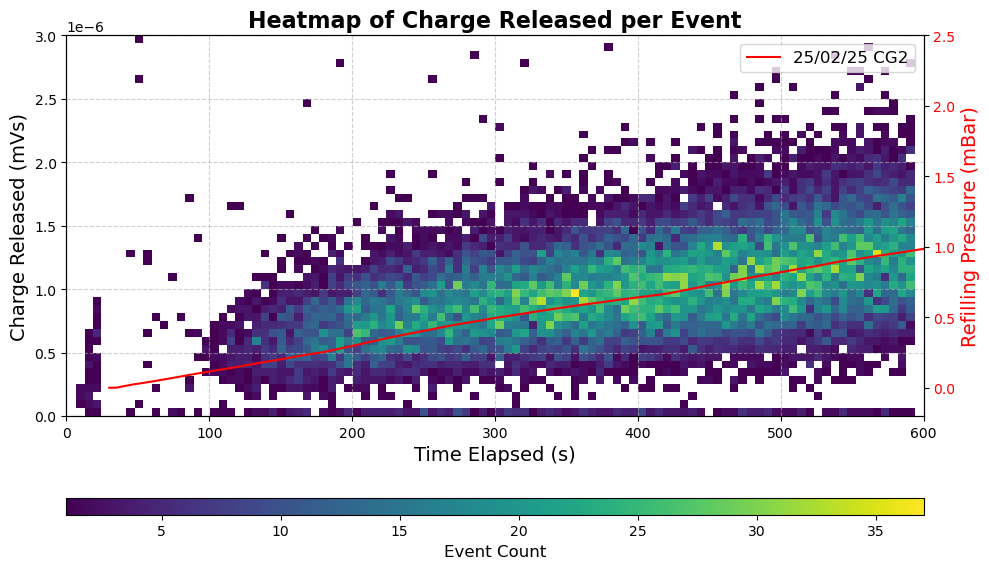

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Load refill data
refill_25_02_25 = np.genfromtxt(
    "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/refill/refill_25_02_25.csv",
    delimiter=',', skip_header=1
)

# Assume areas1 is defined
event_numbers1 = x1.timestamp.values * 8e-9  # For the first dataset (time in seconds)
event_numbers2 = refill_25_02_25[:, 3]       # For the refill data (time or event index)
refill_data = refill_25_02_25[:, 2]          # Refilling pressure (mBar)

# Create the base figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create a 2D histogram (heatmap) of charge released vs time
hb = ax1.hist2d(event_numbers1, areas1, bins=[100, 3000], cmap='viridis', cmin=1)

# Add horizontal colorbar below the plot
cb = fig.colorbar(hb[3], ax=ax1, orientation='horizontal', pad=0.15, aspect=50)
cb.set_label('Event Count', fontsize=12)

# Axis labels
ax1.set_xlabel("Time Elapsed (s)", fontsize=14)
ax1.set_ylabel("Charge Released (mVs)", fontsize=14)
ax1.set_ylim(0, 3e-6)
ax1.set_xlim(0, 600)

# Create twin y-axis for refilling pressure
ax2 = ax1.twinx()
ax2.plot(event_numbers2, refill_data, color='r', linewidth=1.5, label="25/02/25 CG2")
ax2.set_ylabel("Refilling Pressure (mBar)", fontsize=14, color='r')
ax2.tick_params(axis='y', labelcolor="r")
ax2.set_ylim(-0.2, 2.5)

# Title and grid
plt.title("Heatmap of Charge Released per Event", fontsize=16, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# Combine legends
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines2, labels2, loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()

In [44]:
areas2, waveforms2, mean2, stdev2, x2 = reprod_avg("RUN2_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304140802-11.h5", "2", disp=False, plot=False)

1.3347794517039947e-06
7.717386696867682e-07


In [45]:
areas3, waveforms3, mean3, stdev3, x3 = reprod_avg("RUN3_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304143956-12.h5", "3", disp=False, plot=False)

1.0435309321528628e-06
4.7648796370679894e-07


In [46]:
areas4, waveforms4, mean4, stdev4, x4 = reprod_avg("RUN4_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304150622-13.h5", "4", disp=False, plot=False)

8.009284582806444e-07
5.807952945555477e-07


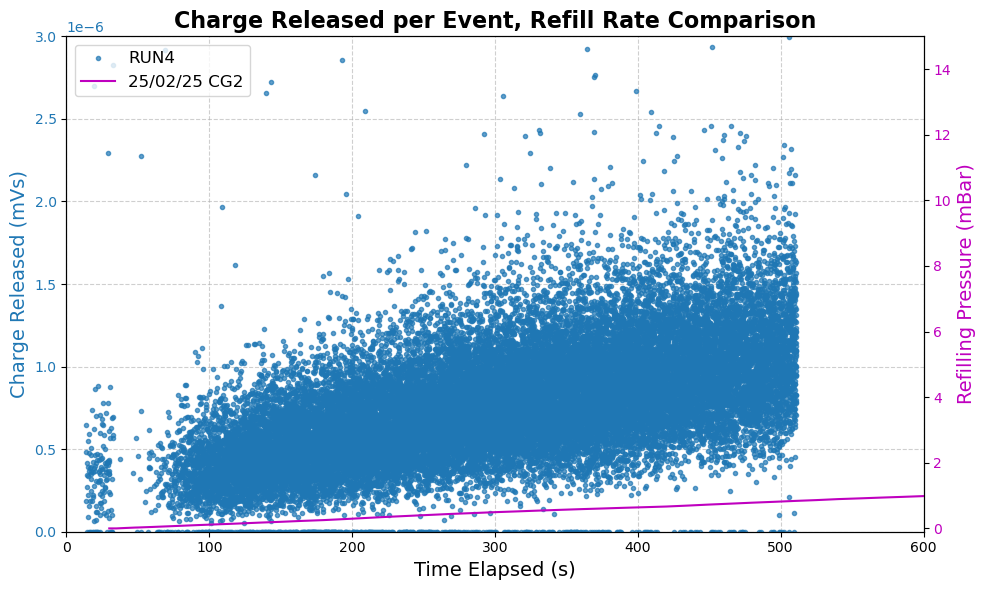

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Load refill data
refill_25_02_25 = np.genfromtxt(
    "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/refill/refill_25_02_25.csv",
    delimiter=',', skip_header=1
)

# Assume areas1 is defined
event_numbers1 = x4.timestamp.values * 8*10**-9  # For the first dataset
event_numbers2 = refill_25_02_25[:, 3]   # For the refill data
refill_data = refill_25_02_25[:, 2]

# Create the base plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first dataset (bottom x-axis, left y-axis)
color1 = 'tab:blue'
ax1.plot(event_numbers1, areas4, '.', color=color1, label="RUN4", alpha=0.7)
ax1.set_xlabel("Time Elapsed (s)", fontsize=14)
ax1.set_ylabel("Charge Released (mVs)", color=color1, fontsize=14)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, 3e-6)

ax3 = ax1.twinx()
ax3.plot(event_numbers2, refill_data, 'm', label="25/02/25 CG2", linewidth=1.5)
ax3.set_ylabel("Refilling Pressure (mBar)", fontsize=14, color='m')
ax3.tick_params(axis='y', labelcolor="m")

# Title and grid
plt.title("Charge Released per Event, Refill Rate Comparison", fontsize=16, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=12)

plt.tight_layout()
plt.xlim(0,600)
plt.ylim(-0.1,15)
#plt.yscale('log')
plt.show()



In [48]:
areas6, waveforms6, mean6, stdev6, x6 = reprod_avg("RUN6_Air_1200V_FsC_dig1-DT5740-915_CH2_20250304160638-15.h5", "6", disp=False, plot=False)

1.5017057602923404e-06
2.285733278515469e-06


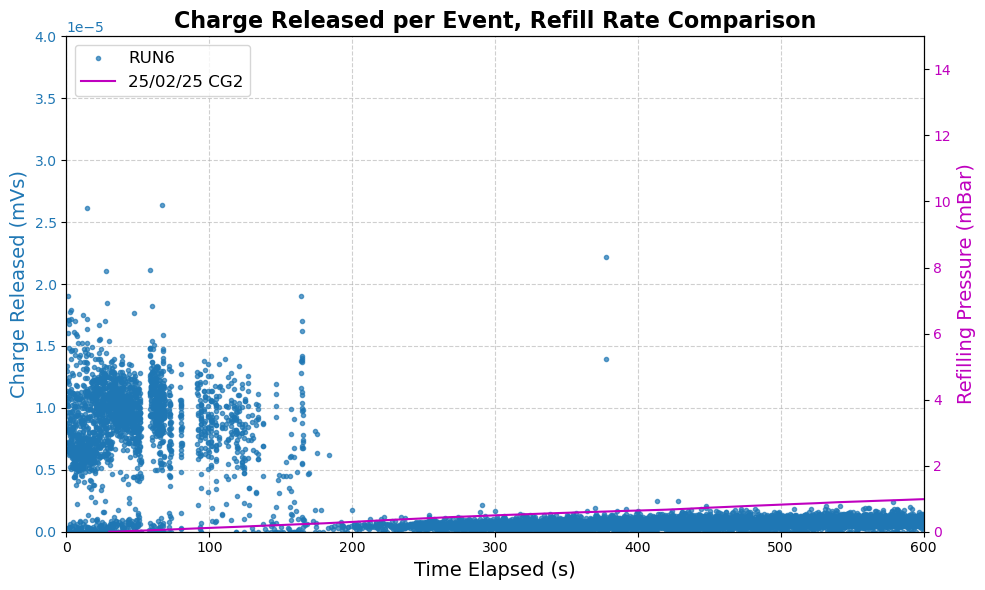

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Load refill data
refill_25_02_25 = np.genfromtxt(
    "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/refill/refill_25_02_25.csv",
    delimiter=',', skip_header=1
)

# Assume areas1 is defined
event_numbers1 = x6.timestamp.values * 8*10**-9  # For the first dataset
event_numbers2 = refill_25_02_25[:, 3]   # For the refill data
refill_data = refill_25_02_25[:, 2]

# Create the base plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first dataset (bottom x-axis, left y-axis)
color1 = 'tab:blue'
ax1.plot(event_numbers1, areas6, '.', color=color1, label="RUN6", alpha=0.7)
ax1.set_xlabel("Time Elapsed (s)", fontsize=14)
ax1.set_ylabel("Charge Released (mVs)", color=color1, fontsize=14)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, 4e-5)

ax3 = ax1.twinx()
ax3.plot(event_numbers2, refill_data, 'm', label="25/02/25 CG2", linewidth=1.5)
ax3.set_ylabel("Refilling Pressure (mBar)", fontsize=14, color='m')
ax3.tick_params(axis='y', labelcolor="m")

# Title and grid
plt.title("Charge Released per Event, Refill Rate Comparison", fontsize=16, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=12)

plt.tight_layout()
plt.xlim(0,600)
plt.ylim(0,15)
plt.show()



In [60]:
from scipy.optimize import curve_fit, root_scalar
from scipy.special import erfc, erfcx
import numpy as np
import matplotlib.pyplot as plt

def emg_pdf(x, mu, sigma, lambd, A):
    """
    Exponentially Modified Gaussian distribution.
    """
    arg = (mu + lambd * sigma**2 - x) / (np.sqrt(2) * sigma)
    return A * (lambd / 2) * np.exp(lambd / 2 * (2 * mu + lambd * sigma**2 - 2 * x)) * erfc(arg)

# Define inverse of erfcx numerically
def erfcxinv(y):
    """
    Numerically computes the inverse of the scaled complementary error function (erfcx).
    Returns np.nan if no valid root is found.
    """
    if y < 1e-6 or y > 1e6:
        return np.nan  # outside stable inversion range
    def func(x):
        return erfcx(x) - y
    try:
        sol = root_scalar(func, bracket=[-10, 10], method='brentq')
        return sol.root if sol.converged else np.nan
    except ValueError:
        return np.nan

def emg_mode(mu, sigma, lambd):
    """
    Computes the mode (peak) of the EMG using the analytical expression with domain-safe inversion.
    Returns np.nan if invalid.
    """
    tau = 1 / lambd
    factor = (abs(tau) / sigma) * np.sqrt(2 / np.pi)
    inv = erfcxinv(factor)
    if np.isnan(inv):
        return np.nan  # fallback or skip this fit
    return mu - np.sign(tau) * np.sqrt(2) * sigma * inv + (sigma**2 / tau)


def emg_fit(data, run):
    # Histogram
    hist_values, bin_edges = np.histogram(data, bins=100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Initial guess
    mu_guess = np.mean(data)
    sigma_guess = np.std(data)
    lambd_guess = 1 / sigma_guess
    A_guess = max(hist_values)
    initial_guess = [mu_guess, sigma_guess, lambd_guess, A_guess]

    try:
        # Fit
        popt, pcov = curve_fit(emg_pdf, bin_centers, hist_values, p0=initial_guess, maxfev=50000)
        mu_fit, sigma_fit, lambd_fit, A_fit = popt
        mu_err, sigma_err, lambd_err, A_err = np.sqrt(np.diag(pcov))

        # Fit curve
        x_fit = np.linspace(min(data), max(data), 500)
        y_fit = emg_pdf(x_fit, *popt)

        # Compute expected values at bin centers for chi-squared
        expected = emg_pdf(bin_centers, *popt)
        mask = expected > 0
        chi_squared = np.sum(((hist_values[mask] - expected[mask]) ** 2) / expected[mask])
        dof = np.sum(mask) - len(popt)  # degrees of freedom = data points - parameters

        # Compute mode
        x_peak = emg_mode(mu_fit, sigma_fit, lambd_fit)

        # Numerical error propagation for mode
        delta = 1e-6
        mode_plus_mu = emg_mode(mu_fit + delta, sigma_fit, lambd_fit)
        mode_plus_sigma = emg_mode(mu_fit, sigma_fit + delta, lambd_fit)
        mode_plus_lambda = emg_mode(mu_fit, sigma_fit, lambd_fit + delta)

        dmode_dmu = (mode_plus_mu - x_peak) / delta
        dmode_dsigma = (mode_plus_sigma - x_peak) / delta
        dmode_dlambda = (mode_plus_lambda - x_peak) / delta

        x_peak_err = np.sqrt(
            (dmode_dmu * mu_err) ** 2 +
            (dmode_dsigma * sigma_err) ** 2 +
            (dmode_dlambda * lambd_err) ** 2
        )

        if np.isnan(x_peak):
            x_peak = np.mean(data)
            x_peak_err = x_peak / len(data)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=100, alpha=0.5, density=False)
        plt.plot(x_fit, y_fit, 'r-', label=(
            f'EMG Fit:\n'
            f'A = {A_fit:.2e} ± {A_err:.2e}\n'
            f'μ = {mu_fit:.2e} ± {mu_err:.2e}\n'
            f'σ = {sigma_fit:.2e} ± {sigma_err:.2e}\n'
            f'λ = {lambd_fit:.2e} ± {lambd_err:.2e}\n'
            f'Reduced χ²≈ {chi_squared/dof:.2f}'
        ))
        plt.axvline(x_peak, color='green', linestyle='--',
                    label=f'MPV ≈ {x_peak:.2e} ± {x_peak_err:.2e}')
        plt.xlabel("Charge released (mVs)")
        plt.ylabel("Events")
        plt.title(f"Charge Histogram - RUN{run}", weight="bold")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    except RuntimeError as e:
        print(f"Fit failed: {e}")
        return None

    return mu_fit, sigma_fit, lambd_fit, mu_err, sigma_err, lambd_err, x_peak, x_peak_err



def fit_routine(areas, nRUN_pressure, run, plot=True):
    start = 0
    fitparams = np.zeros((len(nRUN_pressure[:,1]), 8))
    for k in range(len(nRUN_pressure[:,1])):
        window = int(nRUN_pressure[:,1][k])
        data = areas[start:window]
        fitparams[k] = emg_fit(data, run + " " + str(p_windows[k]) + "-" + str(p_windows[k+1]) + "mBar")
        start = int(window)
    return fitparams

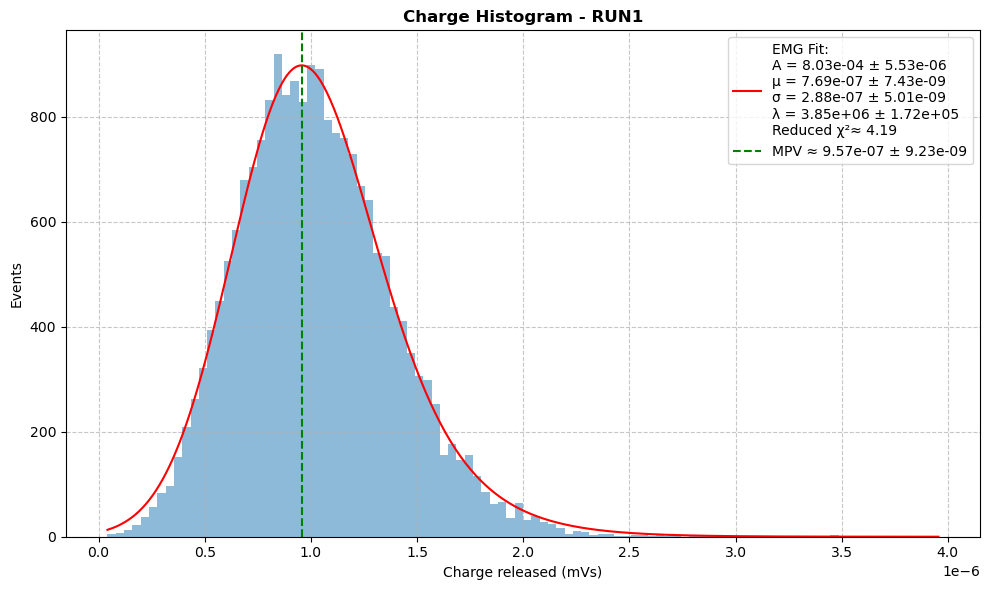

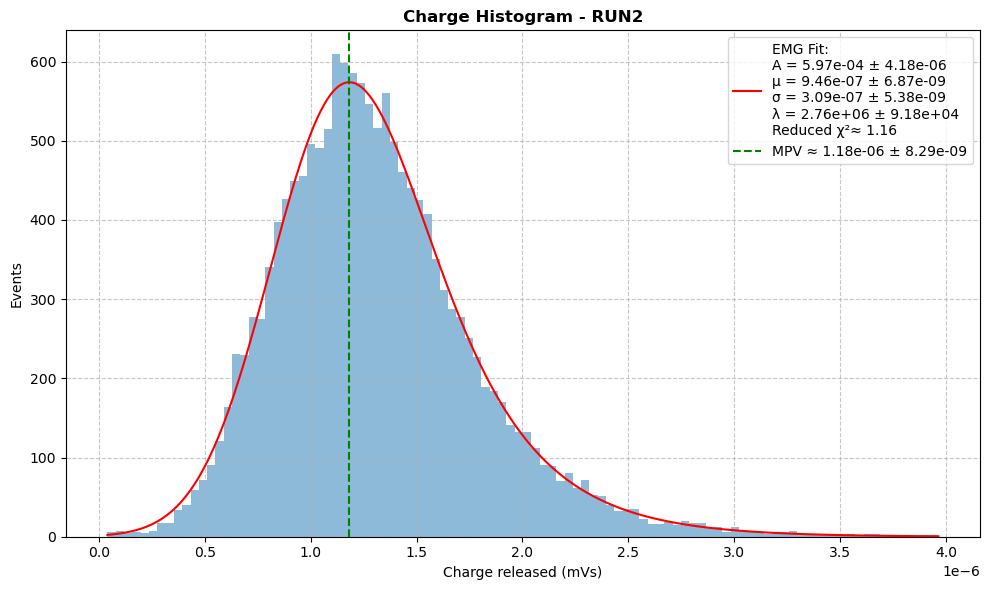

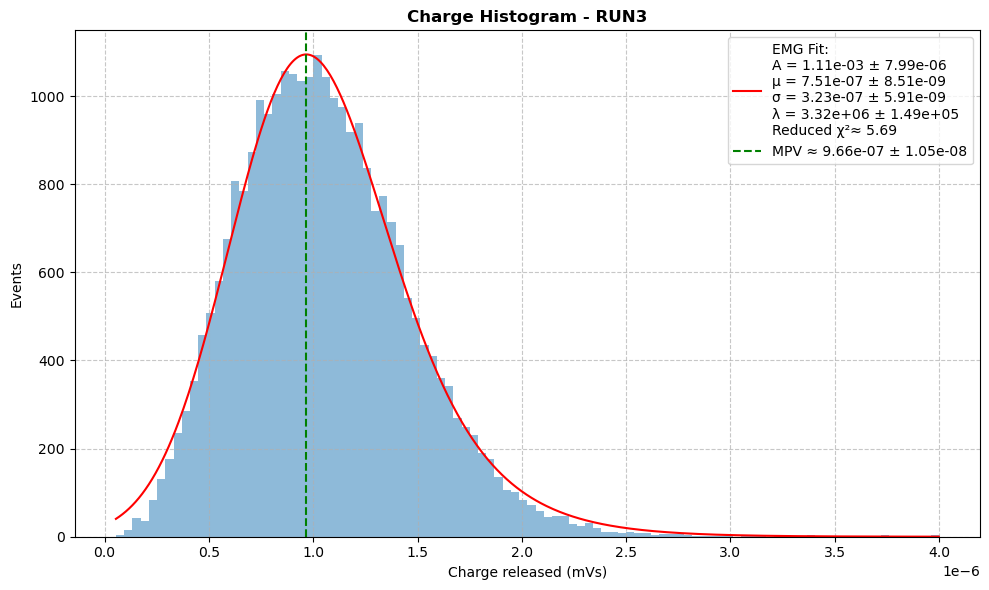

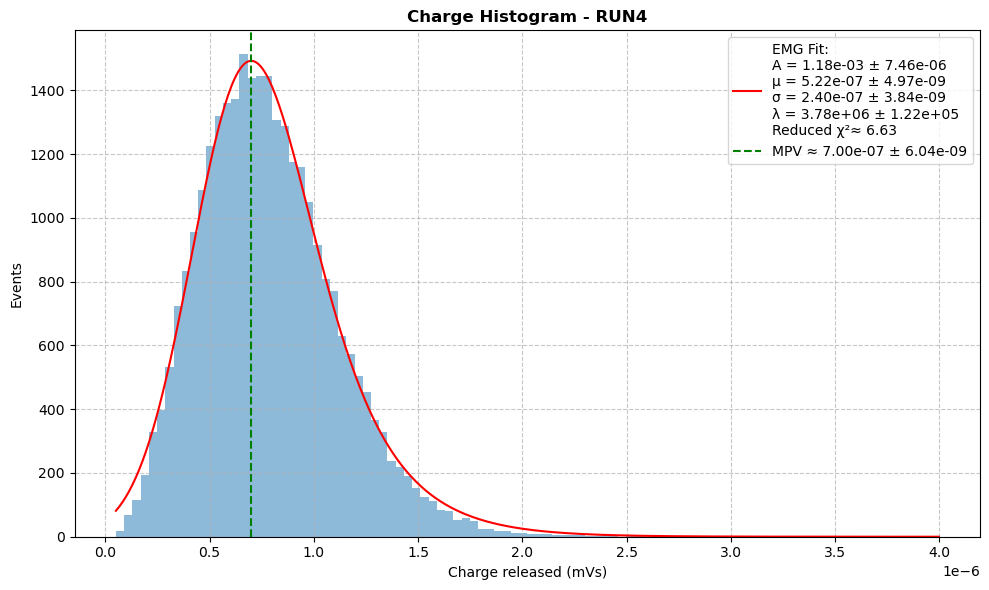

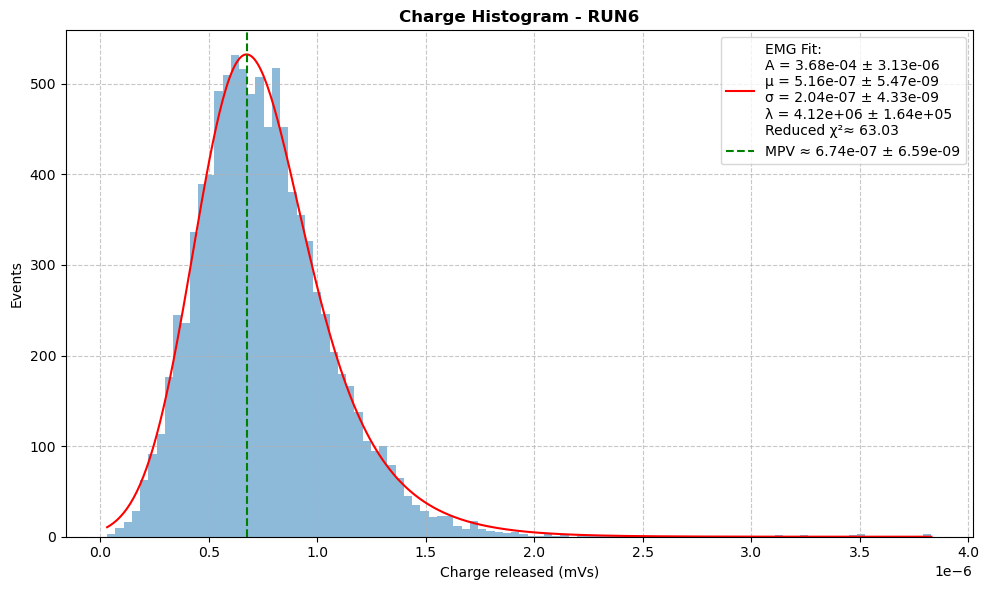

9.566399738705217e-07 1.182812326059683e-06 9.66476163476593e-07 6.99652439574927e-07 6.743978969804039e-07


In [61]:
areas1_filt = areas1[areas1 < 0.000004]
areas2_filt = areas2[areas2 < 0.000004]
areas3_filt = areas3[areas3 < 0.000004]
areas4_filt = areas4[areas4 < 0.000004]
areas6_filt = areas6[areas6 < 0.000004]

mu_fit1, sigma_fit1, lambd_fit1, mu_err1, sigma_err1, lambd_err1, peak1, peak_err1 = emg_fit(areas1_filt[areas1_filt != 0], "1")
mu_fit2, sigma_fit2, lambd_fit2, mu_err2, sigma_err2, lambd_err2, peak2, peak_err2 = emg_fit(areas2_filt[areas2_filt != 0], "2")
mu_fit3, sigma_fit3, lambd_fit3, mu_err3, sigma_err3, lambd_err3, peak3, peak_err3 = emg_fit(areas3_filt[areas3_filt != 0], "3")
mu_fit4, sigma_fit4, lambd_fit4, mu_err4, sigma_err4, lambd_err4, peak4, peak_err4 = emg_fit(areas4_filt[areas4_filt != 0], "4")
mu_fit6, sigma_fit6, lambd_fit6, mu_err6, sigma_err6, lambd_err6, peak6, peak_err6 = emg_fit(areas6_filt[areas6_filt != 0], "6")
print(peak1, peak2, peak3, peak4, peak6)

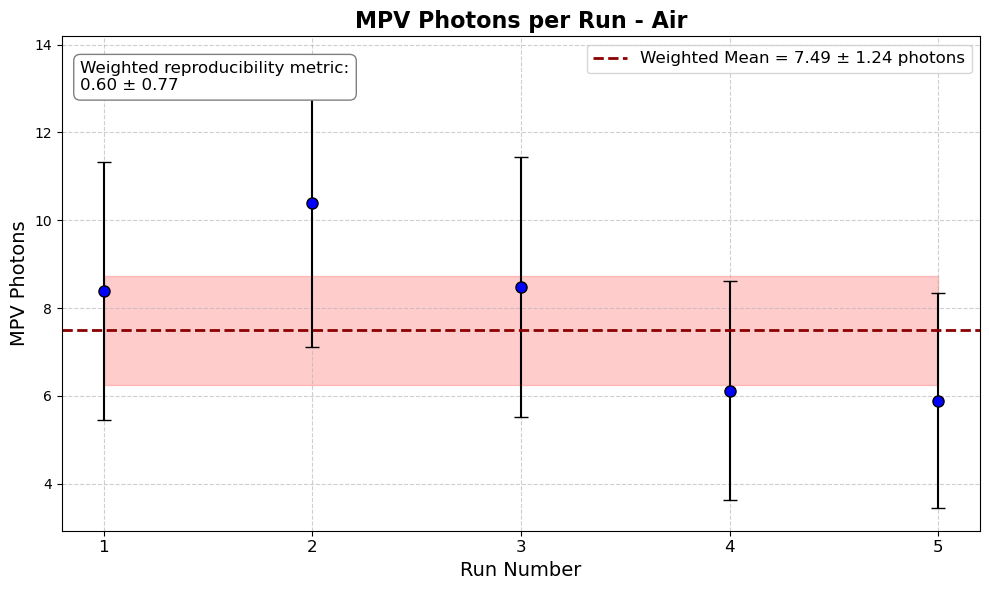

In [52]:
mpvs = np.array([peak1, peak2, peak3, peak4, peak6])
photons = (mpvs / 1e3 - 8.42e-12) / 1.13e-10
mpv_errs = np.array([peak_err1, peak_err2, peak_err3, peak_err4, peak_err6])
photon_err = np.sqrt((np.sqrt((mpv_errs / mpvs) ** 2 + (6.71e-12 / 1.13e-10) ** 2) * photons + 1.11e-11)**2 + photons)

x_vals = np.arange(len(mpvs))
x_labels = [1, 2, 3, 4, 5]

# Compute the weighted mean and its error
weights = 1 / photon_err**2
constant_fit = np.sum(photons * weights) / np.sum(weights)
constant_fit_err = np.sqrt(1 / np.sum(weights))

import matplotlib.pyplot as plt
import numpy as np

# Use a clean style
plt.style.use("default")

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data with error bars
ax.errorbar(
    x_vals, photons, yerr=photon_err, fmt='o',
    markersize=8, capsize=5, color='blue', ecolor='black',
    markeredgecolor='black'
)

# Horizontal fit line and uncertainty
ax.axhline(y=constant_fit, color='darkred', linestyle='--', linewidth=2,
           label=f'Weighted Mean = {constant_fit:.2f} ± {constant_fit_err:.2f} photons')
ax.fill_between(
    x_vals,
    constant_fit - constant_fit_err,
    constant_fit + constant_fit_err,
    color='red', alpha=0.2
)

# X ticks and labels
ax.set_xticks(x_vals)
ax.set_xticklabels(x_labels, fontsize=12)

# Labels and title
ax.set_xlabel("Run Number", fontsize=14)
ax.set_ylabel("MPV Photons", fontsize=14)
ax.set_title("MPV Photons per Run - Air", fontsize=16, weight='bold')

# Annotation for reproducibility
repro_diff = (photons[1] - photons[4]) / constant_fit
repro_err = np.sqrt(((photon_err[1] + photon_err[4])/(photons[1] - photons[4]))**2 + (constant_fit_err/constant_fit)**2) * repro_diff
annot_text = f"Weighted reproducibility metric:\n{repro_diff:.2f} ± {repro_err:.2f}"

# Place annotation in upper left corner
ax.text(0.02, 0.95, annot_text, transform=ax.transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4'))

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=12)

# Layout
plt.tight_layout()
plt.show()